# KPI Utilization

This file will calculate the utilization rate of bikes for a given point in time, which is the number of bikes that is rented out in that moment, divided by the total number of bikes.


In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
# read in data
data = pd.read_csv("csvs/p.csv", index_col=0)


# Calculate total number of bikes (in use)


In [3]:
groupedByBike = data.groupby("bike_id")[
    'start_station_name']
# highest key
maxBikeID = list(groupedByBike.groups)[-1]
# number of unique bike_ids
noBikeIDs = len(groupedByBike.count())
noBikeIDs


1468

In [4]:
# convert dates from string to datetime
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])


The follwing parts will use noBikeIDs(number of unique bikes seen at least once in data set) only, since bikes with IDs that were not used in a year are most likely not in service anymore.


# Hourly utilization of bikes


In [5]:
hData = data[["start_time", "end_time", "bike_id"]]
# add columns in which hour of the year the trip was started/ended
hData["start_hour"] = (hData["start_time"].dt.dayofyear-1) * \
    24+hData["start_time"].dt.hour
hData["end_hour"] = (hData["end_time"].dt.year-2018)*365*24 + (hData["end_time"].dt.dayofyear-1) * \
    24+hData["end_time"].dt.hour
hData = hData.drop(["start_time", "end_time"], axis=1)
hData

bike_id  start_hour  end_hour
0          3708           0         0
1          3288           0        10
2         11735           0         1
3          5202           1         1
4          5142           1         1
...         ...         ...       ...
671813    14519        8759      8760
671814    11891        8759      8760
671815     5410        8759      8766
671816     2701        8759      8759
671817     3471        8759      8759

[668591 rows x 3 columns]

In [6]:
sDate = dt.datetime(2018, 1, 1, 0)
usedPerHour = pd.DataFrame(columns=list(
    ['number_bikes_used', '%bikes_used']))
# calculate number of unique bikes used per hour
for x in range(8760):
    todayData = hData[(hData["start_hour"] <= x) & (hData["end_hour"] >= x)]
    noTrips = len(todayData["bike_id"].unique())
    usedPerHour.loc[x] = [noTrips, noTrips/noBikeIDs*100]
# add date column
dates = []
for x in range(len(usedPerHour)):
    dates.append(sDate+dt.timedelta(hours=x))
usedPerHour["date_time"] = dates
usedPerHour


number_bikes_used  %bikes_used           date_time
0                   3.0     0.204360 2018-01-01 00:00:00
1                   7.0     0.476839 2018-01-01 01:00:00
2                  12.0     0.817439 2018-01-01 02:00:00
3                   5.0     0.340599 2018-01-01 03:00:00
4                   4.0     0.272480 2018-01-01 04:00:00
...                 ...          ...                 ...
8755               27.0     1.839237 2018-12-31 19:00:00
8756               19.0     1.294278 2018-12-31 20:00:00
8757               13.0     0.885559 2018-12-31 21:00:00
8758                8.0     0.544959 2018-12-31 22:00:00
8759               12.0     0.817439 2018-12-31 23:00:00

[8760 rows x 3 columns]

In [7]:
usedPerHour.plot(x="date_time", y="number_bikes_used",
                 title="Absolute number of unique bikes used in hour x")


<AxesSubplot:title={'center':'Absolute number of unique bikes used in hour x'}, xlabel='date_time'>

<AxesSubplot:title={'center':'Percentage of the bike fleet used at least once in hour x'}, xlabel='date_time'>

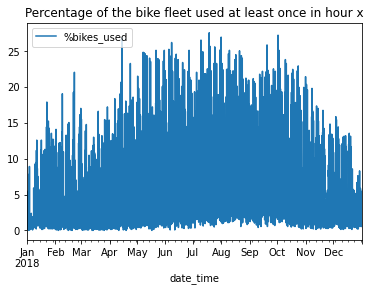

In [8]:
usedPerHour.plot(x="date_time", y="%bikes_used",
                 title="Percentage of the bike fleet used at least once in hour x")


#### zooming in on the summer months


Text(0.5, 1.0, 'Percentage of the bike fleet used at least once in hour x')

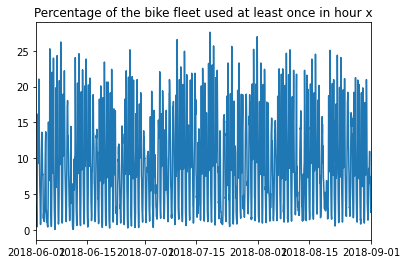

In [9]:
plt.plot(usedPerHour["date_time"], usedPerHour["%bikes_used"])
# june - august
plt.xlim(dt.date(2018, 6, 1), dt.date(2018, 9, 1))
plt.title("Percentage of the bike fleet used at least once in hour x")


hourly utilization peaks around the 25% mark in summer. In winter months this peak seems to be around 15% suggesting much lower usage rates in winter.


# Daily utilization


In [10]:
usedPerDay = pd.DataFrame(columns=list(
    ['day', 'number_bikes_used', '%bikes_used']))
# calculate number/percentage of bikes used each day
for x in range(365):
    # list of bikes used on day x
    f = data[(data["start_time"] <= sDate+dt.timedelta(days=x+1))
             & (data["end_time"] >= sDate+dt.timedelta(days=x))]
    usedPerDay.loc[x] = [sDate+dt.timedelta(days=x), len(f["bike_id"].unique()), len(
        f["bike_id"].unique())/noBikeIDs*100]
usedPerDay


day number_bikes_used  %bikes_used
0   2018-01-01               146     9.945504
1   2018-01-02               381    25.953678
2   2018-01-03               508    34.604905
3   2018-01-04                86     5.858311
4   2018-01-05               174    11.852861
..         ...               ...          ...
360 2018-12-27               480    32.697548
361 2018-12-28               242    16.485014
362 2018-12-29               433    29.495913
363 2018-12-30               404    27.520436
364 2018-12-31               313    21.321526

[365 rows x 3 columns]

In [11]:
usedPerDay.plot(x="day", y="number_bikes_used",
                title="Absolute number of unique bikes used on day x")


<AxesSubplot:title={'center':'Absolute number of unique bikes used on day x'}, xlabel='day'>

In [12]:
usedPerDay.plot(x="day", y="%bikes_used",
                title="Percentage of the bike fleet used at least once on day x")


<AxesSubplot:title={'center':'Percentage of the bike fleet used at least once on day x'}, xlabel='day'>

Up to 60 percent of bikes are used at least once a day. The difference between peaks in summer and winter is less noticable here, but the low points are much lower in winter, suggesting that bad weather has a stronger effect on usage rates in colder months.


## Average Utilization per Bike


In [13]:
avgTripsPerBikeTotal = round(len(data)/len(data["bike_id"].unique()), 2)
print("Mean trips per Bike: " + str(avgTripsPerBikeTotal))
impData = data[["start_time", "bike_id"]]
medianTripsPerBikeTotal = impData.groupby(
    "bike_id").count()["start_time"].median()
print("Median trips per Bike: " + str(medianTripsPerBikeTotal))


Mean trips per Bike: 455.44
Median trips per Bike: 447.5


Each bike is used more than once a day on average. The median and mean trips are relatively similar, suggesting a limited number of outliers.


In [14]:
# add month and remove date column
impData["month"] = impData["start_time"].dt.month
impData = impData[["bike_id", "month"]]
impData


bike_id  month
0          3708      1
1          3288      1
2         11735      1
3          5202      1
4          5142      1
...         ...    ...
671813    14519     12
671814    11891     12
671815     5410     12
671816     2701     12
671817     3471     12

[668591 rows x 2 columns]

In [15]:
means = []
medians = []
for x in range(1, 13):
    monthData = impData[impData["month"] == x].groupby("bike_id").count()
    means.append(len(impData[impData["month"] == x])/len(monthData))
    medians.append(monthData["month"].median())
medians


[24.0, 29.0, 29.0, 43.0, 61.0, 65.0, 62.0, 58.0, 49.0, 50.0, 30.0, 21.0]

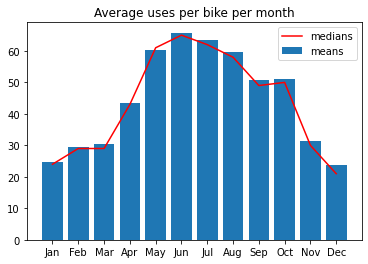

In [16]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(months, height=means, label="means")
plt.plot(months, medians, label="medians", color="red")
plt.title("Average uses per bike per month")
plt.legend()


The overall shape of the graph is similar to the total number of rides per month, suggesting that individual bikes are picked in a similar fashion throughout the year.

Medians and means are once again fairly similar, so outliers are also not too prevalent here.
